In [20]:
from DLtools.Data_preprocess import load_data, series_to_supervised

import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed


In [2]:
r='data/instant_data/rain_small.csv'
w='data/instant_data/water_small.csv'
rw = load_data(r,w)
df =rw.df.resample('d').mean()

DataFrame shape: (465169, 35)


In [42]:
X_in = df['2013-01-01':'2015-01-01'].interpolate(limit=7)
X_in = X_in.astype('float32')
X_in = df.iloc[:,:8].fillna(0)
scale = MinMaxScaler()
X_in = scale.fit_transform(X_in)
X_in

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.02014652, 0.        , ..., 0.50684932, 0.02051282,
        0.03640257],
       [0.        , 0.02014652, 0.        , ..., 0.01369863, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [46]:
ratio = int(len(X_in)*.7)
print(ratio)
#train,test = X_in.iloc[:700,:].values,X_in.iloc[700:777,:].values
train,test = X_in[:700,:],X_in[700:777,:]

train = np.array(np.split(train, len(train)/7))
test = np.array(np.split(test, len(test)/7))

X_in.shape,train.shape,test.shape

1938


((2769, 8), (100, 7, 8), (11, 7, 8))

In [47]:
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
    # flatten data
    try :
        data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    except:
        data = train.values
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out   
        # ensure we have enough data for this instance
        if out_end <= len(data):
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
        # move along one time step
        in_start += 1
    return np.array(X), np.array(y)

In [48]:
# train the model
def build_model(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 0, 70, 16
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# define model
	model = Sequential()
	model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
	model.add(Dense(100, activation='relu'))
	model.add(Dense(n_outputs))
	model.compile(loss='mse', optimizer='adam')
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model

In [49]:
# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = np.array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, 0]
	# reshape into [1, n_input, 1]
	input_x = input_x.reshape((1, len(input_x), 1))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = math.sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = math.sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

In [50]:
# evaluate a single model
def evaluate_model(train, test, n_input):
	# fit model
	model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = np.array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores

In [51]:
n_input = 7

train_x, train_y = to_supervised(train, n_input)
# define parameters
verbose, epochs, batch_size = 0, 70, 16
n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
# define model
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs))
model.compile(loss='mse', optimizer='adam')
model.summary()
# fit network
model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 200)               161600    
_________________________________________________________________
dense_14 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_15 (Dense)             (None, 7)                 707       
Total params: 182,407
Trainable params: 182,407
Non-trainable params: 0
_________________________________________________________________


In [53]:
score, scores = evaluate_model(train, test, n_input)

def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))
# summarize scores
summarize_scores('lstm', score, scores)

lstm: [0.028] 0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0


# Trial with seq2seq

In [57]:
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

def build_model_seq2seq(train, n_input):
    # define parameters
    train_x, train_y = to_supervised(train, n_input)
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # define model
    verbose, epochs, batch_size = 0, 50, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # reshape output into [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    # define model
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(RepeatVector(n_outputs))                                  # Decoder 
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    model.summary()
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model
# evaluate a single model
def evaluate_model(train, test, n_input):
	# fit model
	model = build_model_seq2seq(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = np.array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores

In [58]:
score, scores = evaluate_model(train, test, n_input)

def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))
# summarize scores
summarize_scores('lstm', score, scores)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 200)               161600    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 7, 200)            0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 7, 200)            320800    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 7, 100)            20100     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 7, 1)              101       
Total params: 502,601
Trainable params: 502,601
Non-trainable params: 0
_________________________________________________________________
lstm: [0.026] 0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0


# Multivariate Seq2seq

In [59]:
def to_supervised(train, n_input, n_out=7):
    # flatten data
    try :
        data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    except:
        data = train.values
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out   
        # ensure we have enough data for this instance
        if out_end <= len(data):
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(data[in_start:in_end, :])
            y.append(data[in_end:out_end, 0])
        # move along one time step
        in_start += 1
    return np.array(X), np.array(y)

# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = np.array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, :]
	# reshape into [1, n_input, 1]
	input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat


In [60]:
score, scores = evaluate_model(train, test, n_input)

def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))
# summarize scores
summarize_scores('lstm', score, scores)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 200)               167200    
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 7, 200)            0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 7, 200)            320800    
_________________________________________________________________
time_distributed_4 (TimeDist (None, 7, 100)            20100     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 7, 1)              101       
Total params: 508,201
Trainable params: 508,201
Non-trainable params: 0
_________________________________________________________________
lstm: [0.026] 0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0


In [63]:
test.shape

(11, 7, 8)

# First Trial (LSTM worked, failed in seq2seq )

In [4]:
n_timestep = 14
n_out = 7

,var(t-30),var(t-29),var(t-28),var(t-27),var(t-26),var(t-25),var(t-24),var(t-23),var(t-22),var(t-21),...,var(t+5),var(t+6),var(t+7),var(t+8),var(t+9),var(t+10),var(t+11),var(t+12),var(t+13),var(t+14)
date,,,,,,,,,,,,,,,,,,,,,
2013-01-31,0.797222,0.636250,0.581458,0.532153,0.530139,0.294375,0.437708,0.343681,0.487361,0.643403,...,0.472500,0.498958,0.491250,0.523472,0.572083,0.619653,0.727639,0.579028,0.733958,0.651806
2013-02-01,0.636250,0.581458,0.532153,0.530139,0.294375,0.437708,0.343681,0.487361,0.643403,0.689583,...,0.498958,0.491250,0.523472,0.572083,0.619653,0.727639,0.579028,0.733958,0.651806,0.540903
2013-02-02,0.581458,0.532153,0.530139,0.294375,0.437708,0.343681,0.487361,0.643403,0.689583,0.831286,...,0.491250,0.523472,0.572083,0.619653,0.727639,0.579028,0.733958,0.651806,0.540903,0.592708
2013-02-03,0.532153,0.530139,0.294375,0.437708,0.343681,0.487361,0.643403,0.689583,0.831286,0.637619,...,0.523472,0.572083,0.619653,0.727639,0.579028,0.733958,0.651806,0.540903,0.592708,0.734236
2013-02-04,0.530139,0.294375,0.437708,0.343681,0.487361,0.643403,0.689583,0.831286,0.637619,0.657778,...,0.572083,0.619653,0.727639,0.579028,0.733958,0.651806,0.540903,0.592708,0.734236,0.582708


In [5]:
# def create_train_test(reframed_data):
#     X = reframed_data.iloc[:,:n_look+1].values
#     Y = reframed_data.iloc[:,n_look+1:].values
#     print("Original...",reframed_data.shape)
#     print(".....X shape:{}, .....Y shape:{}".format(X.shape, Y.shape))
#     print("*"*50)
#     len_train = int(len(reframed_data)*0.7)   
#     trainX,trainY = X[:len_train,:], Y[:len_train,:]
#     testX,testY = X[len_train:,:], Y[len_train:,:]   
#     print("trainX shape:{}, trianY shape:{}".format(trainX.shape, trainY.shape))
#     print(".testX shape:{}, .testY shape:{}".format(testX.shape, testY.shape))
#     print("*"*50)
#     ''' Re-shaping data for model requirement '''
#     trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
#     testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
#     print('Training data size:',trainX.shape)
#     print('Test data size:',testX.shape)
#     return trainX,trainY,testX,testY


In [6]:
# trainX,trainY,testX,testY = create_train_test(reframed_data)

Original... (687, 45)
.....X shape:(687, 31), .....Y shape:(687, 14)
**************************************************
trainX shape:(480, 31), trianY shape:(480, 14)
.testX shape:(207, 31), .testY shape:(207, 14)
**************************************************
Training data size: (480, 1, 31)
Test data size: (207, 1, 31)


In [7]:
from sklearn.metrics import mean_squared_error
import math
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
    scores = list()
    mse_scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = math.sqrt(mse)
        # store
        scores.append(rmse)
        mse_scores.append(mse)
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = math.sqrt(s / (actual.shape[0] * actual.shape[1]))
    mse_score = (s / (actual.shape[0] * actual.shape[1]))
    return mse_score,mse_scores,score, scores
# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))

In [8]:
# train the model
def build_model(train_x, train_y, n_input,validation):
    # define parameters
    verbose, epochs, batch_size = 0, 70, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # define model
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mse', optimizer='adam')
    model.summary()
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose,validation_data=validation)
    return model

In [9]:
validation = (testX,testY)
model = build_model(trainX,trainY,n_look,validation)

yhat= model.predict(testX)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200)               185600    
_________________________________________________________________
dense (Dense)                (None, 100)               20100     
_________________________________________________________________
dense_1 (Dense)              (None, 14)                1414      
Total params: 207,114
Trainable params: 207,114
Non-trainable params: 0
_________________________________________________________________


In [10]:
mse_score,mse_scores,score, scores = evaluate_forecasts(testY,yhat)


In [12]:
def summarize_scores(name, mse_score,mse_scores,score, scores):
    mse_s_scores = ', '.join(['%.2f' % s for s in mse_scores])
    s_scores = ', '.join(['%.2f' % s for s in scores])
    print('RMSE %s: [%.3f] %s' % (name, mse_score, mse_s_scores))
    print('MSE %s: [%.3f] %s' % (name, score, s_scores))
# summarize scores
summarize_scores('lstm',mse_score,mse_scores,score, scores)

RMSE lstm: [0.040] 0.03, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04
MSE lstm: [0.201] 0.18, 0.19, 0.19, 0.20, 0.20, 0.21, 0.21, 0.21, 0.21, 0.20, 0.21, 0.20, 0.20, 0.21


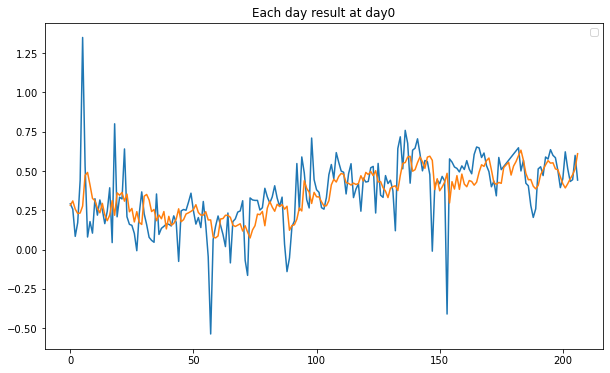

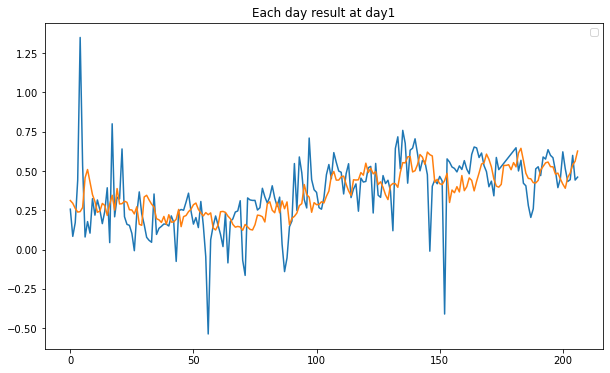

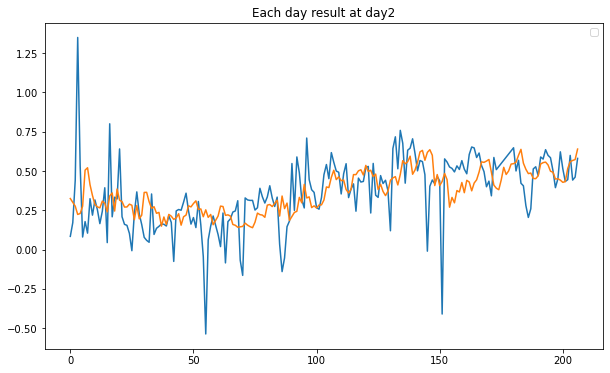

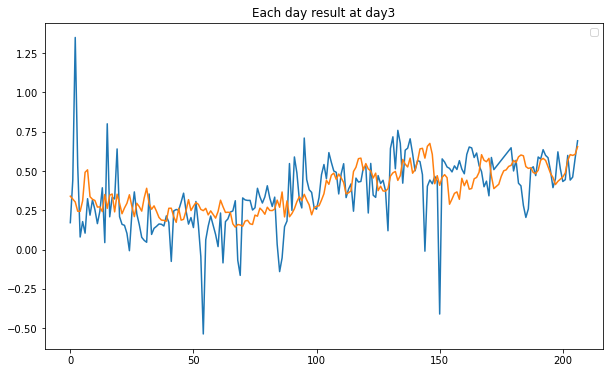

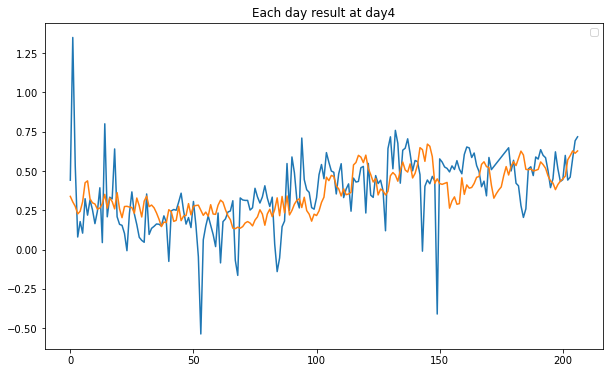

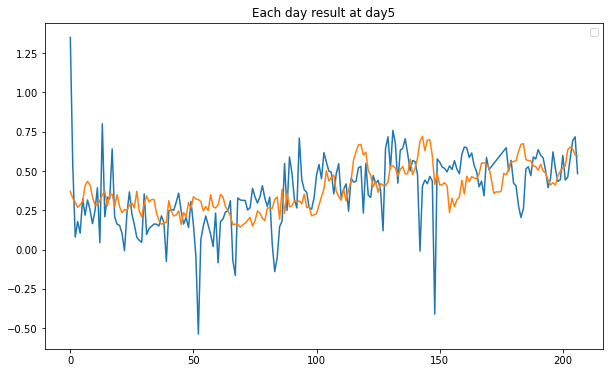

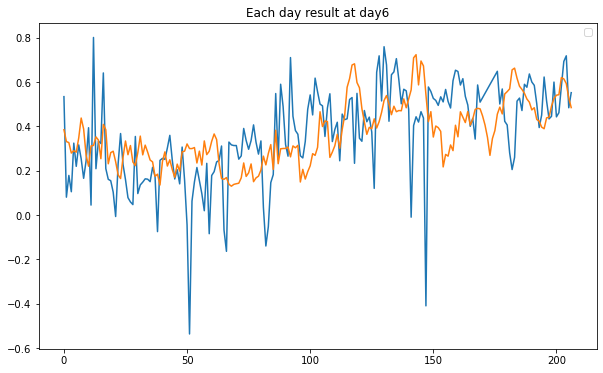

In [39]:
day = list()
# for i in range(7):
#     plt.plot(testY[:,i])
#     plt.plot(yhat[:,i])
#     day.append(str(i))
for n_day in range(7):
    plt.figure(figsize=(10,6))    
    plt.plot(testY[:,n_day])
    plt.plot(yhat[:,n_day])
    plt.title('Each day result at day{}'.format(n_day))
    plt.legend(day)
    plt.show()

# Trial Seq2seq

In [35]:
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

def build_model_seq2seq(train_x, train_y, n_input,validation):
    # define parameters

    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # define model
    verbose, epochs, batch_size = 0, 50, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # reshape output into [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    # define model
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(RepeatVector(n_outputs))                                  # Decoder 
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    model.summary()
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose,validation_data=validation)
    return model

In [37]:
#validation = (testX,testY)
#model_seq2seq = build_model_seq2seq(trainX,trainY,n_look,validation)

model_seq2seq = build_model_seq2seq(train_x,train_y,7,validation=None)

#yhat= model_seq2seq.predict(testX)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 200)               161600    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 7, 200)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 7, 200)            320800    
_________________________________________________________________
time_distributed (TimeDistri (None, 7, 100)            20100     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 7, 1)              101       
Total params: 502,601
Trainable params: 502,601
Non-trainable params: 0
_________________________________________________________________


NameError: name 'testX' is not defined

In [40]:
# summarize scores
mse_score,mse_scores,score,scores = evaluate_forecasts(testY,yhat)
summarize_scores('lstm_seq2seq',mse_score,mse_scores,score,scores)

RMSE lstm_seq2seq: [0.040] 0.03, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04
MSE lstm_seq2seq: [0.200] 0.18, 0.19, 0.20, 0.20, 0.20, 0.21, 0.20, 0.21, 0.21, 0.21, 0.21, 0.20, 0.20, 0.19


# Multivariate Trial

In [42]:
X = df.interpolate(limit=300)
X = X.astype('float32')
X = X.iloc[:,:10] # filter noly sample 10 row
X = X.fillna(0)

In [43]:
n_look = 30
n_t_predict = 15

reframed_data = series_to_supervised(X,n_look,n_t_predict,True)
reframed_data.head()

,CHM002_r(t-30),CHM004_r(t-30),CHM006_r(t-30),CPY004_r(t-30),CPY009_r(t-30),CPY010_r(t-30),CPY015_r(t-30),KWN002_r(t-30),NAN006_r(t-30),NAN010_r(t-30),...,CHM002_r(t+14),CHM004_r(t+14),CHM006_r(t+14),CPY004_r(t+14),CPY009_r(t+14),CPY010_r(t+14),CPY015_r(t+14),KWN002_r(t+14),NAN006_r(t+14),NAN010_r(t+14)
date,,,,,,,,,,,,,,,,,,,,,
2013-01-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,9.835714,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-02-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,10.200000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-02-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.6,0.000000,0.0,0.0,0.0,0.4,0.0,0.0,0.0
2013-02-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.6,19.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-02-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
trainX,trainY,testX,testY = create_train_test(reframed_data)

Original... (2725, 450)
.....X shape:(2725, 31), .....Y shape:(2725, 419)
**************************************************
trainX shape:(1907, 31), trianY shape:(1907, 419)
.testX shape:(818, 31), .testY shape:(818, 419)
**************************************************
Training data size: (1907, 1, 31)
Test data size: (818, 1, 31)


In [46]:
validation = (testX,testY)
model_seq2seq = build_model_seq2seq(trainX,trainY,n_look,validation)

yhat= model_seq2seq.predict(testX)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 200)               185600    
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 419, 200)          0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 419, 200)          320800    
_________________________________________________________________
time_distributed_6 (TimeDist (None, 419, 100)          20100     
_________________________________________________________________
time_distributed_7 (TimeDist (None, 419, 1)            101       
Total params: 526,601
Trainable params: 526,601
Non-trainable params: 0
_________________________________________________________________


In [41]:
# summarize scores
mse_score,mse_scores,score,scores = evaluate_forecasts(testY,yhat)
summarize_scores('Multivairate_lstm_seq2seq', mse_score,mse_scores,score,scores)

RMSE Multivairate_lstm_seq2seq: [0.040] 0.03, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04
MSE Multivairate_lstm_seq2seq: [0.200] 0.18, 0.19, 0.20, 0.20, 0.20, 0.21, 0.20, 0.21, 0.21, 0.21, 0.21, 0.20, 0.20, 0.19
